### World Data Science Institute Internship
#### Q Learning Environment Setup and BackGround
#### Deep Reinforcement Learning with Microsoft Azure

By Brandon Oppong-Antwi



----

Important Notes on Installations:

Python Version: Python 3

Tensorflow Version: Tensorflow 1.14.0

Pytorch Version: Pytorch  1.6.0 with CUDA 101

Operating System: Windows 10


## Azure Preambles and Installation Requirements

Most of the requirements of python packages are already fulfilled on Azure. However, in order to create the graphs and the time series analysis we need to make sure we have the correct version of tensorflow running as well as important imports like glob for file handling, pandas for data frames, and numpy for muti-dimensional array analysis.

In [29]:




!pip install tensorflow==1.14 #use this import an older version of tensorflow in order to run placeholders and other deprecated features



# importing the dependencies
import numpy as np # linear algebra
import tensorflow as tf #machine learning
import pandas as pd # dataframe
from glob import glob # file handling
from tqdm import tqdm # progress bar
from collections import deque # for simpler implementation of memory
import seaborn as sns #data visualization
sns.set()

import matplotlib.pyplot as plt # visualisation
%matplotlib inline

### Some helper functions below

Below is the code for some helper functions and is consistent across various models.

In [30]:
# function to properly return the string of price
def format_price(price):
    return ("-$" if price < 0 else "$") + "{0:.2f}".format(abs(price))

# sigmoid function in neural network analysis
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# function to get the state
def get_state(data, t, n):
    d = t - n + 1
    if d >= 0:
        block = data[d:t+1]
    else:
        # pad with t0
        block = -d*[data[0]] + data[0:t+1].tolist()
        
    
    # get results
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    
    # return numpy array
    return np.array([res])

### Load Data

The code below is to load the data and is similar across various models.

In [31]:
# load the csv file
# Colab Preambles and Installation Requirements

# load and run the csv file
data = pd.read_csv('SQ.csv')

# Constants 
LOG = False
episode_count = 10 #how many episodes to run at once
window_size = 100
data = data['Close'].values # what our data is
len_data = len(data) - 1 # total information length
batch_size = 32 # minibatch size

# logs
loss_global = []
profits_global = []

Text(0.5, 1.0, '- Square')

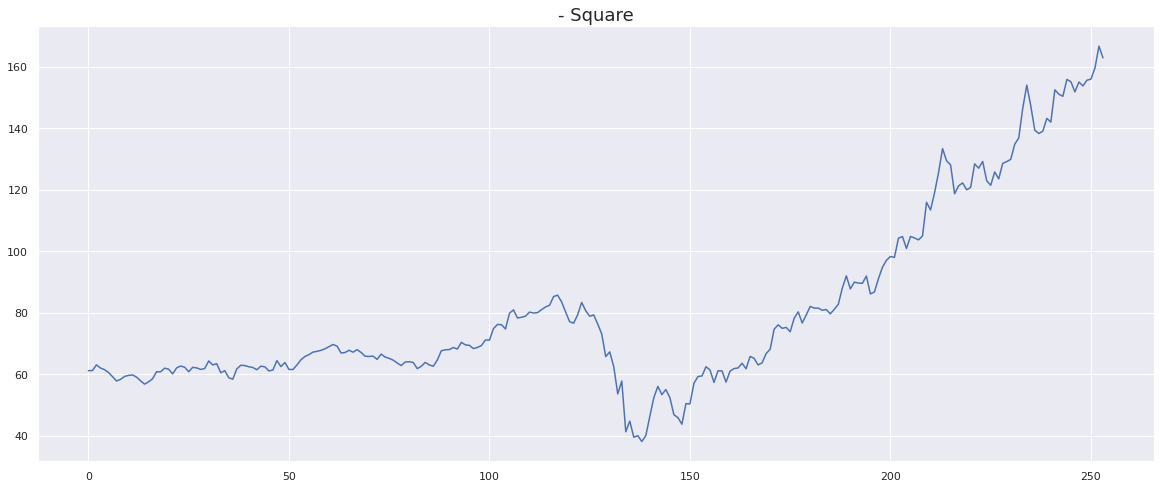

In [32]:
plt.figure(figsize = (20, 8))
plt.plot(data)
plt.title( '- Square', fontsize = 18)

# Q-Learning with Replay Buffer

The Algorithm we are implementing here is the following Q learning with Replay Buffer.

nce replay buffers, which allow a reinforcement learning (RL) agent to store experiences in the form of transition tuples, usually denoted as (st,at,rt,st+1) with states, actions, rewards, and successor states at some time index t. In contrast to consuming samples online and discarding them thereafter, sampling from the stored experiences means they are less heavily “correlated” and can be re-used for learning

In [33]:
class AgentDQN():
    # init functions
    def __init__(self, input_dim, scope, is_eval = False, epsilon_decay_steps = 1000):
        # input_dim: state size
        # is_eval: is being evaluated
        # scope: scope of the model
        self.state_size = input_dim
        self.action_space = 3 # sell, sit, buy
        self.memory = deque(maxlen = 10000)
        self.inventory = [] # holdings that we have
        self.scope = scope # name of scope
        self.is_eval = is_eval # whether in training or deployment
        self.gamma = 0.95 # discount factor

        # greedy-epsilon policy
        self.epsilon = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay_val = (self.epsilon - self.epsilon_end)/epsilon_decay_steps

        # code to load previously trained model --> skip for now
        # self.model = load_model("models/" + model_name) if is_eval else self._model()
        self._build_model()
        self._build_loss()
        self.initialize_network()

    # inhouse functions
    def _build_model(self):
        self.input_placeholder = tf.placeholder(tf.float32, [None, self.state_size], name = 'inputs')
        self.target_placeholder = tf.placeholder(tf.float32, [None, self.action_space], name = 'target_value')

        # layers
        h1 = tf.contrib.layers.fully_connected(self.input_placeholder, 64)
        h2 = tf.contrib.layers.fully_connected(h1, 32)
        h3 = tf.contrib.layers.fully_connected(h2, 8)
        self.action_pred = tf.contrib.layers.fully_connected(h3, self.action_space)

        # print the values
        print('inputs:', self.input_placeholder)
        print('target_value:', self.target_placeholder)
        print('action_pred:', self.action_pred)

    def _build_loss(self):
        self.loss = tf.reduce_mean(tf.square(self.target_placeholder - self.action_pred))
        print('loss:', self.loss)
        self.update_step = tf.train.AdamOptimizer(0.001).minimize(self.loss)

    # user callable functions
    def initialize_network(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def save_model(self, frozen = False):
        # code to save the model as frozen inference graph (optional) or 
        # checkpoint file (default)
        if frozen:
            # convert to frozen graph here
            model_path = 'some_path'
            print('Model saved at {0}'.format(some_path))
            return
        return

    # operation functions
    def act(self, state):
        if not self.is_eval and np.random.random() <= self.epsilon:
            return np.random.randint(self.action_space)

        # else use the model to predict action
        action_dist = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
        return np.argmax(action_dist[0])

    def experience_replay(self, batch_size):
        # make the minibatch
        mini_batch = []
        mem_len = len(self.memory)
        for i in range(mem_len - batch_size + 1, mem_len):
            mini_batch.append(self.memory[i])

        # loss log
        loss_log = []

        for state, action, reward, next_state, done in mini_batch:
            target_s = reward
            if not done:
                # get predictions from model
                pred = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: next_state})

                # get the target value to be fit
                target_s = reward + self.gamma*np.amax(pred[0])

            # target value to be fit upon
            target_y = self.sess.run(self.action_pred, feed_dict = {self.input_placeholder: state})
            target_y[0][action] = target_s

            # train the model
            feed_dict = {self.input_placeholder: state, self.target_placeholder: target_y}
            loss, _ = self.sess.run([self.loss, self.update_step], feed_dict = feed_dict)

            # add to logs
            loss_log.append(loss)

        # reduce the value of epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_val

        # return loss
        return loss_log

In [34]:
# define the agent
agent = AgentDQN(window_size, 'model_pre')

inputs: Tensor("inputs_5:0", shape=(?, 100), dtype=float32)
target_value: Tensor("target_value_2:0", shape=(?, 3), dtype=float32)
action_pred: Tensor("fully_connected_25/Relu:0", shape=(?, 3), dtype=float32)
loss: Tensor("Mean_6:0", shape=(), dtype=float32)


In [35]:
# run things
for e in range(episode_count):
    state = get_state(data, 0, window_size + 1)

    # init values for new episode
    total_profit = 0.0 # total profit in this epoch
    agent.inventory = [] # reset the inventory
    total_loss = [] # at each step what was the total loss
    mean_loss = [] # at each step what was the mean loss

    for t in tqdm(range(len_data)):
        action = agent.act(state)

        # next state
        next_state = get_state(data, t + 1, window_size + 1)
        reward = 0

        # now go according to actions
        if action == 2:
            # buy
            agent.inventory.append(data[t])
            if LOG:
                print('Buy:' + format_price(data[t]))


        elif action == 0 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0) # remove the first element and return the value
            profit = data[t] - bought_price # profit this iteration
            reward = max(data[t] - bought_price, 0) # reward
            total_profit += profit # add to total profit
            if LOG:
                print("Sell: " + format_price(data[t]) + " | Profit: " + format_price(profit))

        # condition for finish
        done = t == len_data - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done and LOG:
            print("Total Profit: " + format_price(total_profit))

        # train the model
        if len(agent.memory) > batch_size:
            losses = agent.experience_replay(batch_size)
            total_loss.append(np.sum(losses))
            mean_loss.append(np.mean(losses))

    # add the mean loss to global loss
    loss_global.append(np.mean(mean_loss))
    profits_global.append(total_profit)
    
    print('[*]Episode: {0}, loss: {1}, profits: {2}'.format(e, loss_global[-1], profits_global[-1]))

100%|██████████| 253/253 [00:08<00:00, 29.43it/s]


[*]Episode: 0, loss: 167.5186004638672, profits: 103.04996100000004
[*]Episode: 1, loss: 68.29962921142578, profits: -40.92995799999994
[*]Episode: 2, loss: 5.433590888977051, profits: 56.969986
[*]Episode: 3, loss: 0.938626766204834, profits: 14.649986999999967
[*]Episode: 4, loss: 0.19370006024837494, profits: 3.5800019999999932
[*]Episode: 5, loss: 0.18382687866687775, profits: 17.770004
[*]Episode: 6, loss: 0.07047442346811295, profits: 2.720001999999994
[*]Episode: 7, loss: 6.45586305836332e-06, profits: 0.07000000000000739
[*]Episode: 8, loss: 0.0, profits: 0.0
[*]Episode: 9, loss: 0.0006455881521105766, profits: 0.7000010000000003


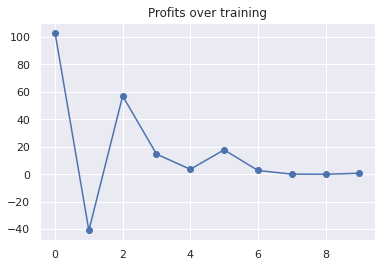

In [36]:
plt.title('Profits over training')
plt.plot(profits_global, '-o')